In [1]:
#!pip install -U "tensorflow>=2.10.0"

In [2]:
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
import tqdm
import random
import pathlib
import itertools
import collections

import shutil
import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf
import matplotlib.pyplot as plt
# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

# Download a subset of the UCF sports actions

The UFC Sports Actions dataset https://www.crcv.ucf.edu/data/UCF_Sports_Action.php contains 10 categories of different sports actions in video, primarily used in action recognition. 

In [4]:
URL = 'https://www.crcv.ucf.edu/data/ucf_sports_actions.zip'

In [5]:
def list_files_from_zip_url(zip_url, verify):
  files = []
  with rz.RemoteZip(zip_url,verify=False) as zip: # I use verify false to ignore problem with ssl certificate
    for zip_info in zip.infolist():
      if (zip_info.filename.endswith('.avi')):
          files.append(zip_info.filename)
  return files

In [6]:
files = list_files_from_zip_url(URL, False) 
files = [f for f in files if f.endswith('.avi')]
files[:10]

C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


['ucf_sports_actions/ucf action/Diving-Side/001/2538-5_70133.avi',
 'ucf_sports_actions/ucf action/Diving-Side/002/2538-11_70015.avi',
 'ucf_sports_actions/ucf action/Diving-Side/003/2538-12_70246.avi',
 'ucf_sports_actions/ucf action/Diving-Side/004/2538-16_70032.avi',
 'ucf_sports_actions/ucf action/Diving-Side/005/4475-1_70541.avi',
 'ucf_sports_actions/ucf action/Diving-Side/006/4475-2_70045.avi',
 'ucf_sports_actions/ucf action/Diving-Side/007/4475-6_70099.avi',
 'ucf_sports_actions/ucf action/Golf-Swing-Back/001/3283-8_700741.avi',
 'ucf_sports_actions/ucf action/Golf-Swing-Back/002/3283-8_701201.avi',
 'ucf_sports_actions/ucf action/Golf-Swing-Back/003/7608-12_70275.avi']

In [7]:
files

['ucf_sports_actions/ucf action/Diving-Side/001/2538-5_70133.avi',
 'ucf_sports_actions/ucf action/Diving-Side/002/2538-11_70015.avi',
 'ucf_sports_actions/ucf action/Diving-Side/003/2538-12_70246.avi',
 'ucf_sports_actions/ucf action/Diving-Side/004/2538-16_70032.avi',
 'ucf_sports_actions/ucf action/Diving-Side/005/4475-1_70541.avi',
 'ucf_sports_actions/ucf action/Diving-Side/006/4475-2_70045.avi',
 'ucf_sports_actions/ucf action/Diving-Side/007/4475-6_70099.avi',
 'ucf_sports_actions/ucf action/Golf-Swing-Back/001/3283-8_700741.avi',
 'ucf_sports_actions/ucf action/Golf-Swing-Back/002/3283-8_701201.avi',
 'ucf_sports_actions/ucf action/Golf-Swing-Back/003/7608-12_70275.avi',
 'ucf_sports_actions/ucf action/Golf-Swing-Back/004/7616-7_70270.avi',
 'ucf_sports_actions/ucf action/Golf-Swing-Back/005/RF1-13903_70070.avi',
 'ucf_sports_actions/ucf action/Golf-Swing-Front/001/7603-4_70159.avi',
 'ucf_sports_actions/ucf action/Golf-Swing-Front/002/7608-9_70(2)151.avi',
 'ucf_sports_actions

In [8]:
def get_class(fname):
  return fname.split('/')[2].replace('-Front','').replace('-Side','').replace('-Back','')

In [9]:
def get_files_per_class(files):
  files_for_class = collections.defaultdict(list)
  for fname in files:
    #print(fname)
    class_name = get_class(fname)
    #print(class_name)
    files_for_class[class_name].append(fname)
  return files_for_class

In [10]:
NUM_CLASSES = 10
FILES_PER_CLASS = 50

In [11]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [12]:
print('Num classes:', len(classes))
videos=0
for i in range (len(classes)):
    print('Num videos for class[',i,']',classes[i],':', len(files_for_class[classes[i]]))
    videos += len(files_for_class[classes[i]])
    
print("Num of videos", videos)

Num classes: 10
Num videos for class[ 0 ] Diving : 7
Num videos for class[ 1 ] Golf-Swing : 18
Num videos for class[ 2 ] Kicking : 20
Num videos for class[ 3 ] Lifting : 6
Num videos for class[ 4 ] Riding-Horse : 12
Num videos for class[ 5 ] Run : 13
Num videos for class[ 6 ] SkateBoarding : 12
Num videos for class[ 7 ] Swing-Bench : 20
Num videos for class[ 8 ] SwingAngle : 13
Num videos for class[ 9 ] Walk : 22
Num of videos 143


In [13]:
def select_subset_of_classes(files_for_class, classes, files_per_class):

  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [14]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['Diving',
 'Golf-Swing',
 'Kicking',
 'Lifting',
 'Riding-Horse',
 'Run',
 'SkateBoarding',
 'Swing-Bench',
 'SwingAngle',
 'Walk']

In [15]:
def download_from_zip(zip_url, to_dir, file_names):

  with rz.RemoteZip(zip_url,verify=False) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      print(class_name)
      print(to_dir)
      print("FN",fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn
      #print("FN",fn)
      fn = pathlib.Path(fn).parts[-1]
      print("FN",fn)
      output_file = to_dir / class_name / fn
     # if (".avi" in str(output_file)): # To do add .avi in str
          #unzipped_file.rename(output_file)
      try:
           unzipped_file.rename(output_file)
      except:
              print("Renaming didn't work because problem with file was occured. Moving on...")
      continue

In [16]:
def split_class_lists(files_for_class, count):

  split_files = []
  remainder = {}
  for cls in files_for_class:
    #print("cls",cls)
    test=len(files_for_class[cls])
    #print("Len of files_for_class[cls]",test)
    #print("test",test * count)
    splt = int(round(test * count))

    #split_files.extend(files_for_class[cls][:test])
    #print("count" , count, type(count))
    #print("splt" , splt, type(splt))
    #splt = count
    split_files.extend(files_for_class[cls][:splt])
   
    remainder[cls] = files_for_class[cls][splt:]
  return split_files, remainder

In [17]:
def download_ucf_subset(zip_url, num_classes, splits, download_dir):

  files = list_files_from_zip_url(zip_url,True)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) 
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    random.shuffle(files_for_class[cls])
    
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    #print(split_name, ":")
    split_dir = download_dir / split_name
    #print("Split dir", split_dir)
    #print("Split name",split_name)
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    #print("Split count", split_count, "split files", split_files,len(split_files)," files for class", files_for_class, "files for class size ",len(files_for_class)) 
    if os.path.exists(str(split_dir)) == 0:
        download_from_zip(zip_url, split_dir, split_files)
    else:
        shutil.rmtree(download_dir)
        download_from_zip(zip_url, split_dir, split_files)
        
        
    dirs[split_name] = split_dir

  return dirs

In [18]:
download_dir = pathlib.Path('./ucf_sports_actions/')
subset_paths = download_ucf_subset(URL,
                                       num_classes = NUM_CLASSES,
                                      #splits = {"train": 30, "val": 10, "test": 10},
                                     # splits = { "val": 2, "test": 1,"train": 20},
                                      splits = { "val": 0.30, "test": 0.1, "train": 1},
                                       download_dir = download_dir)

C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\

Diving
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Diving-Side/007/4475-6_70099.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  2%|█▉                                                                                 | 1/44 [00:01<01:11,  1.66s/it]

FN 4475-6_70099.avi
Diving
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Diving-Side/004/2538-16_70032.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  5%|███▊                                                                               | 2/44 [00:02<00:49,  1.18s/it]

FN 2538-16_70032.avi
Golf-Swing
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Golf-Swing-Side/002/RF1-11456_70034.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  7%|█████▋                                                                             | 3/44 [00:03<00:45,  1.10s/it]

FN RF1-11456_70034.avi
Golf-Swing
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Golf-Swing-Side/005/7606-2_700810.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  9%|███████▌                                                                           | 4/44 [00:05<00:52,  1.30s/it]

FN 7606-2_700810.avi
Golf-Swing
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Golf-Swing-Front/004/RF1-13206_70024.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 11%|█████████▍                                                                         | 5/44 [00:06<00:52,  1.36s/it]

FN RF1-13206_70024.avi
Golf-Swing
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Golf-Swing-Back/004/7616-7_70270.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.44s/it]

FN 7616-7_70270.avi
Golf-Swing
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Golf-Swing-Back/003/7608-12_70275.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 16%|█████████████▏                                                                     | 7/44 [00:09<00:55,  1.51s/it]

FN 7608-12_70275.avi
Kicking
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Kicking-Front/001/778-62_l146.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.47s/it]

FN 778-62_l146.avi
Kicking
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Kicking-Side/007/6351-1_70011.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 20%|████████████████▉                                                                  | 9/44 [00:12<00:49,  1.42s/it]

FN 6351-1_70011.avi
Kicking
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Kicking-Front/004/3937-9_70105.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 23%|██████████████████▋                                                               | 10/44 [00:13<00:47,  1.39s/it]

FN 3937-9_70105.avi
Kicking
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Kicking-Front/007/6063-21_70056.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 25%|████████████████████▌                                                             | 11/44 [00:15<00:46,  1.42s/it]

FN 6063-21_70056.avi
Kicking
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Kicking-Front/010/6731-2_70017.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 27%|██████████████████████▎                                                           | 12/44 [00:16<00:42,  1.34s/it]

FN 6731-2_70017.avi
Kicking
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Kicking-Side/008/pstch3_clp16_0079_l050.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 30%|████████████████████████▏                                                         | 13/44 [00:17<00:39,  1.27s/it]

FN pstch3_clp16_0079_l050.avi
Lifting
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Lifting/006/3528-10_70424.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 32%|██████████████████████████                                                        | 14/44 [00:20<00:49,  1.67s/it]

FN 3528-10_70424.avi
Lifting
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Lifting/003/2502-3_70368.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:48,  1.68s/it]

FN 2502-3_70368.avi
Riding-Horse
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Riding-Horse/006/6018-29_70000.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:45,  1.62s/it]

FN 6018-29_70000.avi
Riding-Horse
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Riding-Horse/007/6029-1_70001.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:44,  1.63s/it]

FN 6029-1_70001.avi
Riding-Horse
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Riding-Horse/009/6326-9_70170.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:42,  1.64s/it]

FN 6326-9_70170.avi
Riding-Horse
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Riding-Horse/001/4456-16_700040.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:39,  1.59s/it]

FN 4456-16_700040.avi
Run
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Run-Side/002/5238-17_700000.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:38,  1.62s/it]

FN 5238-17_700000.avi
Run
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Run-Side/008/7850-5_70090.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:37,  1.62s/it]

FN 7850-5_70090.avi
Run
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Run-Side/003/5238-17_700641.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:31,  1.43s/it]

FN 5238-17_700641.avi
Run
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Run-Side/011/5117-8_70157.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.49s/it]

FN 5117-8_70157.avi
SkateBoarding
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/SkateBoarding-Front/004/761-39000.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:28,  1.44s/it]

FN 761-39000.avi
SkateBoarding
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/SkateBoarding-Front/012/1058-22003.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.51s/it]

FN 1058-22003.avi
SkateBoarding
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/SkateBoarding-Front/002/708-77009.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:28,  1.57s/it]

FN 708-77009.avi
SkateBoarding
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/SkateBoarding-Front/008/860-38064.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:27,  1.61s/it]

FN 860-38064.avi
Swing-Bench
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Swing-Bench/014/2527-12_70360.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:25,  1.59s/it]

FN 2527-12_70360.avi
Swing-Bench
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Swing-Bench/006/2527-5_70020.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:23,  1.59s/it]

FN 2527-5_70020.avi
Swing-Bench
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Swing-Bench/012/2527-12_70186.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.55s/it]

FN 2527-12_70186.avi
Swing-Bench
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Swing-Bench/015/2527-12_70411.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.53s/it]

FN 2527-12_70411.avi
Swing-Bench
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Swing-Bench/019/2527-12_70641.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.57s/it]

FN 2527-12_70641.avi
Swing-Bench
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Swing-Bench/003/669-60220.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:17,  1.58s/it]

FN 669-60220.avi
SwingAngle
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Swing-SideAngle/009/vid1_0377.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:15,  1.60s/it]

FN vid1_0377.avi
SwingAngle
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Swing-SideAngle/011/vid1_0855.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:14,  1.61s/it]

FN vid1_0855.avi
SwingAngle
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Swing-SideAngle/007/4367-6_70167.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:13,  1.68s/it]

FN 4367-6_70167.avi
SwingAngle
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Swing-SideAngle/008/vid1_0302.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.57s/it]

FN vid1_0302.avi
Walk
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Walk-Front/019/RF1-18602_70140.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:58<00:09,  1.64s/it]

FN RF1-18602_70140.avi
Walk
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Walk-Front/015/RF1-18566_700411.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:08,  1.63s/it]

FN RF1-18566_700411.avi
Walk
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Walk-Front/002/5561-7_70102.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:01<00:06,  1.67s/it]

FN 5561-7_70102.avi
Walk
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Walk-Front/004/RF1-10799_70080.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:03<00:05,  1.71s/it]

FN RF1-10799_70080.avi
Walk
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Walk-Front/016/RF1-18566_700560.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:04<00:03,  1.69s/it]

FN RF1-18566_700560.avi
Walk
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Walk-Front/011/RF1-18085_70010.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:06<00:01,  1.68s/it]

FN RF1-18085_70010.avi
Walk
ucf_sports_actions\val
FN ucf_sports_actions/ucf action/Walk-Front/021/RF1-13205_70100.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:08<00:00,  1.55s/it]

FN RF1-13205_70100.avi



C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

Golf-Swing
ucf_sports_actions\test
FN ucf_sports_actions/ucf action/Golf-Swing-Front/006/RF1-13428_70288.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 11%|█████████▎                                                                          | 1/9 [00:01<00:12,  1.51s/it]

FN RF1-13428_70288.avi
Kicking
ucf_sports_actions\test
FN ucf_sports_actions/ucf action/Kicking-Front/005/3949-12_70207.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 22%|██████████████████▋                                                                 | 2/9 [00:02<00:09,  1.40s/it]

FN 3949-12_70207.avi
Riding-Horse
ucf_sports_actions\test
FN ucf_sports_actions/ucf action/Riding-Horse/004/4456-16_700406.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 33%|████████████████████████████                                                        | 3/9 [00:04<00:09,  1.52s/it]

FN 4456-16_700406.avi
Run
ucf_sports_actions\test
FN ucf_sports_actions/ucf action/Run-Side/012/7603-3_70195.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 44%|█████████████████████████████████████▎                                              | 4/9 [00:06<00:07,  1.54s/it]

FN 7603-3_70195.avi
SkateBoarding
ucf_sports_actions\test
FN ucf_sports_actions/ucf action/SkateBoarding-Front/006/860-2729.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:07<00:06,  1.59s/it]

FN 860-2729.avi
Swing-Bench
ucf_sports_actions\test
FN ucf_sports_actions/ucf action/Swing-Bench/013/2527-12_70297.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 67%|████████████████████████████████████████████████████████                            | 6/9 [00:09<00:04,  1.57s/it]

FN 2527-12_70297.avi
SwingAngle
ucf_sports_actions\test
FN ucf_sports_actions/ucf action/Swing-SideAngle/005/vid8_0500.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:10<00:02,  1.38s/it]

FN vid8_0500.avi
Walk
ucf_sports_actions\test
FN ucf_sports_actions/ucf action/Walk-Front/018/RF1-18598_70530.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:11<00:01,  1.46s/it]

FN RF1-18598_70530.avi
Walk
ucf_sports_actions\test
FN ucf_sports_actions/ucf action/Walk-Front/010/RF1-18075_70140.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.51s/it]

FN RF1-18075_70140.avi



C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  0%|                                                                                           | 0/90 [00:00<?, ?it/s]

Diving
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Diving-Side/002/2538-11_70015.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  1%|▉                                                                                  | 1/90 [00:00<01:13,  1.21it/s]

FN 2538-11_70015.avi
Diving
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Diving-Side/006/4475-2_70045.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  2%|█▊                                                                                 | 2/90 [00:01<01:21,  1.08it/s]

FN 4475-2_70045.avi
Diving
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Diving-Side/001/2538-5_70133.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  3%|██▊                                                                                | 3/90 [00:03<01:44,  1.20s/it]

FN 2538-5_70133.avi
Diving
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Diving-Side/003/2538-12_70246.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  4%|███▋                                                                               | 4/90 [00:05<01:59,  1.38s/it]

FN 2538-12_70246.avi
Diving
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Diving-Side/005/4475-1_70541.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  6%|████▌                                                                              | 5/90 [00:06<02:03,  1.46s/it]

FN 4475-1_70541.avi
Golf-Swing
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Golf-Swing-Front/007/RF1-13588_70046.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  7%|█████▌                                                                             | 6/90 [00:08<02:10,  1.56s/it]

FN RF1-13588_70046.avi
Golf-Swing
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Golf-Swing-Front/005/RF1-13209_70050.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  8%|██████▍                                                                            | 7/90 [00:09<02:10,  1.57s/it]

FN RF1-13209_70050.avi
Golf-Swing
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Golf-Swing-Front/008/RF1-13678_70045.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  9%|███████▍                                                                           | 8/90 [00:11<02:06,  1.54s/it]

FN RF1-13678_70045.avi
Golf-Swing
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Golf-Swing-Front/002/7608-9_70(2)151.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 10%|████████▎                                                                          | 9/90 [00:12<02:02,  1.52s/it]

FN 7608-9_70(2)151.avi
Golf-Swing
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Golf-Swing-Front/003/RF1-13157_70040.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 11%|█████████                                                                         | 10/90 [00:14<02:01,  1.52s/it]

FN RF1-13157_70040.avi
Golf-Swing
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Golf-Swing-Side/001/RF1-13207_7015.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 12%|██████████                                                                        | 11/90 [00:15<02:00,  1.53s/it]

FN RF1-13207_7015.avi
Golf-Swing
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Golf-Swing-Side/003/7608-5_70308.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 13%|██████████▉                                                                       | 12/90 [00:17<01:59,  1.53s/it]

FN 7608-5_70308.avi
Golf-Swing
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Golf-Swing-Back/002/3283-8_701201.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 14%|███████████▊                                                                      | 13/90 [00:18<01:55,  1.50s/it]

FN 3283-8_701201.avi
Golf-Swing
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Golf-Swing-Back/005/RF1-13903_70070.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 16%|████████████▊                                                                     | 14/90 [00:20<01:58,  1.55s/it]

FN RF1-13903_70070.avi
Golf-Swing
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Golf-Swing-Front/001/7603-4_70159.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 17%|█████████████▋                                                                    | 15/90 [00:22<01:53,  1.52s/it]

FN 7603-4_70159.avi
Golf-Swing
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Golf-Swing-Side/004/7608-5_70039.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 18%|██████████████▌                                                                   | 16/90 [00:23<01:45,  1.42s/it]

FN 7608-5_70039.avi
Golf-Swing
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Golf-Swing-Back/001/3283-8_700741.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 19%|███████████████▍                                                                  | 17/90 [00:24<01:44,  1.43s/it]

FN 3283-8_700741.avi
Kicking
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Kicking-Front/003/3833-27_70006.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 20%|████████████████▍                                                                 | 18/90 [00:25<01:36,  1.34s/it]

FN 3833-27_70006.avi
Kicking
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Kicking-Side/010/RF1-16941_70021.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 21%|█████████████████▎                                                                | 19/90 [00:26<01:31,  1.29s/it]

FN RF1-16941_70021.avi
Kicking
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Kicking-Side/005/5863-29_70025.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 22%|██████████████████▏                                                               | 20/90 [00:28<01:28,  1.27s/it]

FN 5863-29_70025.avi
Kicking
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Kicking-Side/004/5117-8_70350.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 23%|███████████████████▏                                                              | 21/90 [00:29<01:25,  1.23s/it]

FN 5117-8_70350.avi
Kicking
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Kicking-Front/002/1084-44_l865.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 24%|████████████████████                                                              | 22/90 [00:30<01:25,  1.26s/it]

FN 1084-44_l865.avi
Kicking
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Kicking-Front/008/6351-6_70000.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 26%|████████████████████▉                                                             | 23/90 [00:31<01:24,  1.26s/it]

FN 6351-6_70000.avi
Kicking
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Kicking-Side/009/pstch3_clp21_0088_l105.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 27%|█████████████████████▊                                                            | 24/90 [00:33<01:21,  1.23s/it]

FN pstch3_clp21_0088_l105.avi
Kicking
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Kicking-Front/009/6729-10_70314.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 28%|██████████████████████▊                                                           | 25/90 [00:34<01:18,  1.21s/it]

FN 6729-10_70314.avi
Kicking
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Kicking-Side/006/6063-20_70333.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 29%|███████████████████████▋                                                          | 26/90 [00:35<01:19,  1.24s/it]

FN 6063-20_70333.avi
Kicking
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Kicking-Side/001/3833-15_70577.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 30%|████████████████████████▌                                                         | 27/90 [00:36<01:19,  1.27s/it]

FN 3833-15_70577.avi
Kicking
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Kicking-Side/003/3833-41_70187.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 31%|█████████████████████████▌                                                        | 28/90 [00:38<01:16,  1.24s/it]

FN 3833-41_70187.avi
Kicking
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Kicking-Front/006/5117-8_70113.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 32%|██████████████████████████▍                                                       | 29/90 [00:39<01:13,  1.21s/it]

FN 5117-8_70113.avi
Kicking
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Kicking-Side/002/3833-40_70336.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 33%|███████████████████████████▎                                                      | 30/90 [00:40<01:11,  1.19s/it]

FN 3833-40_70336.avi
Lifting
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Lifting/005/3528-6_70270.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 34%|████████████████████████████▏                                                     | 31/90 [00:42<01:20,  1.37s/it]

FN 3528-6_70270.avi
Lifting
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Lifting/001/3528-8_70514.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 36%|█████████████████████████████▏                                                    | 32/90 [00:43<01:24,  1.46s/it]

FN 3528-8_70514.avi
Lifting
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Lifting/004/3528-6_70(2)268.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 37%|██████████████████████████████                                                    | 33/90 [00:45<01:28,  1.56s/it]

FN 3528-6_70(2)268.avi
Lifting
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Lifting/002/2502-2_70340.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 38%|██████████████████████████████▉                                                   | 34/90 [00:47<01:29,  1.60s/it]

FN 2502-2_70340.avi
Riding-Horse
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Riding-Horse/010/RF1-12001_70063.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 39%|███████████████████████████████▉                                                  | 35/90 [00:48<01:28,  1.62s/it]

FN RF1-12001_70063.avi
Riding-Horse
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Riding-Horse/008/6029-1_70143.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 40%|████████████████████████████████▊                                                 | 36/90 [00:50<01:27,  1.62s/it]

FN 6029-1_70143.avi
Riding-Horse
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Riding-Horse/012/7467-18_70103.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 41%|█████████████████████████████████▋                                                | 37/90 [00:52<01:23,  1.58s/it]

FN 7467-18_70103.avi
Riding-Horse
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Riding-Horse/011/1098-6_70000.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 42%|██████████████████████████████████▌                                               | 38/90 [00:53<01:21,  1.57s/it]

FN 1098-6_70000.avi
Riding-Horse
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Riding-Horse/005/4456-16_700516.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 43%|███████████████████████████████████▌                                              | 39/90 [00:55<01:22,  1.61s/it]

FN 4456-16_700516.avi
Riding-Horse
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Riding-Horse/002/4456-16_700165.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 44%|████████████████████████████████████▍                                             | 40/90 [00:56<01:18,  1.58s/it]

FN 4456-16_700165.avi
Riding-Horse
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Riding-Horse/003/4456-16_700273.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 46%|█████████████████████████████████████▎                                            | 41/90 [00:58<01:15,  1.55s/it]

FN 4456-16_700273.avi
Run
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Run-Side/005/5238-17_701581.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 47%|██████████████████████████████████████▎                                           | 42/90 [00:59<01:16,  1.59s/it]

FN 5238-17_701581.avi
Run
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Run-Side/006/5238-17_701141.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 48%|███████████████████████████████████████▏                                          | 43/90 [01:01<01:14,  1.58s/it]

FN 5238-17_701141.avi
Run
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Run-Side/007/6065-8_70110.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 49%|████████████████████████████████████████                                          | 44/90 [01:03<01:12,  1.58s/it]

FN 6065-8_70110.avi
Run
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Run-Side/004/5238-17_700950.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 50%|█████████████████████████████████████████                                         | 45/90 [01:04<01:11,  1.59s/it]

FN 5238-17_700950.avi
Run
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Run-Side/013/5020-1_70062.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 51%|█████████████████████████████████████████▉                                        | 46/90 [01:05<01:02,  1.41s/it]

FN 5020-1_70062.avi
Run
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Run-Side/009/3687-17_70245.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 52%|██████████████████████████████████████████▊                                       | 47/90 [01:07<01:02,  1.46s/it]

FN 3687-17_70245.avi
Run
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Run-Side/010/5373-10_70026.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 53%|███████████████████████████████████████████▋                                      | 48/90 [01:08<01:01,  1.47s/it]

FN 5373-10_70026.avi
Run
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Run-Side/001/2670-5_70111.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 54%|████████████████████████████████████████████▋                                     | 49/90 [01:10<01:00,  1.47s/it]

FN 2670-5_70111.avi
SkateBoarding
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/SkateBoarding-Front/010/947-70005.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 56%|█████████████████████████████████████████████▌                                    | 50/90 [01:12<01:02,  1.55s/it]

FN 947-70005.avi
SkateBoarding
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/SkateBoarding-Front/007/860-37150.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 57%|██████████████████████████████████████████████▍                                   | 51/90 [01:13<01:01,  1.57s/it]

FN 860-37150.avi
SkateBoarding
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/SkateBoarding-Front/005/860-2001.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 58%|███████████████████████████████████████████████▍                                  | 52/90 [01:15<01:00,  1.59s/it]

FN 860-2001.avi
SkateBoarding
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/SkateBoarding-Front/011/947-70454.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 59%|████████████████████████████████████████████████▎                                 | 53/90 [01:16<00:59,  1.60s/it]

FN 947-70454.avi
SkateBoarding
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/SkateBoarding-Front/001/708-75070.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 60%|█████████████████████████████████████████████████▏                                | 54/90 [01:18<00:58,  1.63s/it]

FN 708-75070.avi
SkateBoarding
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/SkateBoarding-Front/009/947-58108.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 61%|██████████████████████████████████████████████████                                | 55/90 [01:20<00:57,  1.65s/it]

FN 947-58108.avi
SkateBoarding
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/SkateBoarding-Front/003/711-66044.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 62%|███████████████████████████████████████████████████                               | 56/90 [01:21<00:55,  1.63s/it]

FN 711-66044.avi
Swing-Bench
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-Bench/020/4379-9_70018.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 63%|███████████████████████████████████████████████████▉                              | 57/90 [01:23<00:53,  1.63s/it]

FN 4379-9_70018.avi
Swing-Bench
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-Bench/010/2527-9_70267.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 64%|████████████████████████████████████████████████████▊                             | 58/90 [01:24<00:50,  1.59s/it]

FN 2527-9_70267.avi
Swing-Bench
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-Bench/011/2527-12_70137.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 66%|█████████████████████████████████████████████████████▊                            | 59/90 [01:26<00:48,  1.56s/it]

FN 2527-12_70137.avi
Swing-Bench
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-Bench/018/2527-12_70574.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 67%|██████████████████████████████████████████████████████▋                           | 60/90 [01:27<00:46,  1.55s/it]

FN 2527-12_70574.avi
Swing-Bench
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-Bench/001/669-60084.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 68%|███████████████████████████████████████████████████████▌                          | 61/90 [01:29<00:44,  1.53s/it]

FN 669-60084.avi
Swing-Bench
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-Bench/016/2527-12_70461.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 69%|████████████████████████████████████████████████████████▍                         | 62/90 [01:30<00:42,  1.51s/it]

FN 2527-12_70461.avi
Swing-Bench
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-Bench/017/2527-12_70526.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 70%|█████████████████████████████████████████████████████████▍                        | 63/90 [01:32<00:40,  1.51s/it]

FN 2527-12_70526.avi
Swing-Bench
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-Bench/007/2527-5_70114.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 71%|██████████████████████████████████████████████████████████▎                       | 64/90 [01:33<00:38,  1.50s/it]

FN 2527-5_70114.avi
Swing-Bench
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-Bench/005/669-67178.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 72%|███████████████████████████████████████████████████████████▏                      | 65/90 [01:35<00:37,  1.49s/it]

FN 669-67178.avi
Swing-Bench
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-Bench/009/2527-9_70087.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 73%|████████████████████████████████████████████████████████████▏                     | 66/90 [01:36<00:35,  1.49s/it]

FN 2527-9_70087.avi
Swing-Bench
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-Bench/002/669-60176.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 74%|█████████████████████████████████████████████████████████████                     | 67/90 [01:38<00:35,  1.52s/it]

FN 669-60176.avi
Swing-Bench
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-Bench/008/2527-9_70018.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 76%|█████████████████████████████████████████████████████████████▉                    | 68/90 [01:40<00:33,  1.54s/it]

FN 2527-9_70018.avi
Swing-Bench
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-Bench/004/669-67070.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 77%|██████████████████████████████████████████████████████████████▊                   | 69/90 [01:41<00:31,  1.52s/it]

FN 669-67070.avi
SwingAngle
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-SideAngle/003/vid6_025.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 78%|███████████████████████████████████████████████████████████████▊                  | 70/90 [01:42<00:27,  1.37s/it]

FN vid6_025.avi
SwingAngle
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-SideAngle/001/vid1_0117.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 79%|████████████████████████████████████████████████████████████████▋                 | 71/90 [01:44<00:26,  1.39s/it]

FN vid1_0117.avi
SwingAngle
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-SideAngle/010/vid1_0674.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 80%|█████████████████████████████████████████████████████████████████▌                | 72/90 [01:45<00:26,  1.46s/it]

FN vid1_0674.avi
SwingAngle
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-SideAngle/012/vid5_000.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 81%|██████████████████████████████████████████████████████████████████▌               | 73/90 [01:47<00:25,  1.52s/it]

FN vid5_000.avi
SwingAngle
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-SideAngle/002/vid1_0461.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 82%|███████████████████████████████████████████████████████████████████▍              | 74/90 [01:48<00:25,  1.56s/it]

FN vid1_0461.avi
SwingAngle
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-SideAngle/013/vid8_0027.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 83%|████████████████████████████████████████████████████████████████████▎             | 75/90 [01:50<00:21,  1.44s/it]

FN vid8_0027.avi
SwingAngle
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-SideAngle/006/vid8_0685.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 84%|█████████████████████████████████████████████████████████████████████▏            | 76/90 [01:51<00:21,  1.52s/it]

FN vid8_0685.avi
SwingAngle
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Swing-SideAngle/004/vid6_214.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 86%|██████████████████████████████████████████████████████████████████████▏           | 77/90 [01:53<00:20,  1.59s/it]

FN vid6_214.avi
Walk
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Walk-Front/003/RF1-10578_70285.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 87%|███████████████████████████████████████████████████████████████████████           | 78/90 [01:55<00:19,  1.59s/it]

FN RF1-10578_70285.avi
Walk
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Walk-Front/007/RF1-14377_70025.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 88%|███████████████████████████████████████████████████████████████████████▉          | 79/90 [01:56<00:17,  1.61s/it]

FN RF1-14377_70025.avi
Walk
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Walk-Front/014/RF1-18526_70364.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 89%|████████████████████████████████████████████████████████████████████████▉         | 80/90 [01:58<00:16,  1.62s/it]

FN RF1-18526_70364.avi
Walk
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Walk-Front/008/RF1-15295_70060.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 90%|█████████████████████████████████████████████████████████████████████████▊        | 81/90 [02:00<00:14,  1.64s/it]

FN RF1-15295_70060.avi
Walk
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Walk-Front/022/7608-3_70626.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 91%|██████████████████████████████████████████████████████████████████████████▋       | 82/90 [02:01<00:13,  1.70s/it]

FN 7608-3_70626.avi
Walk
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Walk-Front/009/RF1-15341_70050.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 92%|███████████████████████████████████████████████████████████████████████████▌      | 83/90 [02:03<00:11,  1.68s/it]

FN RF1-15341_70050.avi
Walk
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Walk-Front/001/3206-12_70000.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 93%|████████████████████████████████████████████████████████████████████████████▌     | 84/90 [02:05<00:09,  1.66s/it]

FN 3206-12_70000.avi
Walk
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Walk-Front/017/RF1-18598_70075.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 94%|█████████████████████████████████████████████████████████████████████████████▍    | 85/90 [02:06<00:08,  1.67s/it]

FN RF1-18598_70075.avi
Walk
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Walk-Front/006/RF1-13902_70016.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 96%|██████████████████████████████████████████████████████████████████████████████▎   | 86/90 [02:08<00:06,  1.65s/it]

FN RF1-13902_70016.avi
Walk
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Walk-Front/013/RF1-18524_70031.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 97%|███████████████████████████████████████████████████████████████████████████████▎  | 87/90 [02:10<00:04,  1.66s/it]

FN RF1-18524_70031.avi
Walk
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Walk-Front/005/RF1-11529_70033.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 98%|████████████████████████████████████████████████████████████████████████████████▏ | 88/90 [02:11<00:03,  1.66s/it]

FN RF1-11529_70033.avi
Walk
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Walk-Front/012/RF1-18156_70301.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 99%|█████████████████████████████████████████████████████████████████████████████████ | 89/90 [02:13<00:01,  1.60s/it]

FN RF1-18156_70301.avi
Walk
ucf_sports_actions\train
FN ucf_sports_actions/ucf action/Walk-Front/020/RF1-13204_70095.avi


C:\Users\MACIEJ\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [02:14<00:00,  1.50s/it]

FN RF1-13204_70095.avi


In [19]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))

video_total = video_count_train + video_count_val + video_count_test
print(video_count_train, video_count_val, video_count_test)
print(f"Total videos: {video_total}")

90 44 9
Total videos: 143


In [20]:
!find ./ucf_sports_actions

FIND: Parameter format not correct


In [21]:
def format_frames(frame, output_size):

  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [22]:
def frames_from_video_file(video_path, n_frames, output_size = (480, 480), frame_step = 5):

  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)

  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [23]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):

    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [24]:
fg = FrameGenerator(subset_paths['train'], len(classes), training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 480, 480, 3)
Label: 3


In [25]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], len(classes), training=True),
                                          output_signature = output_signature)

In [26]:
for frames, labels in train_ds.take(len(classes)):
  print(labels)

tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(9, shape=(), dtype=int16)
tf.Tensor(7, shape=(), dtype=int16)
tf.Tensor(7, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)
tf.Tensor(7, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)


In [27]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], len(classes)),
                                        output_signature = output_signature)

In [28]:
for frames, labels in val_ds.take(len(classes)):
  print(labels)

tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)


In [29]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 480, 480, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 480, 480, 3)
Shape of validation labels: ()


In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [31]:
train_ds = train_ds.batch(18)
val_ds = val_ds.batch(18)

In [32]:

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (18, 10, 480, 480, 3)
Shape of training labels: (18,)
Shape of validation set of frames: (18, 10, 480, 480, 3)
Shape of validation labels: (18,)


In [33]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

history = model.fit(train_ds, 
          epochs = 40,
          validation_data = val_ds #)
          ,callbacks = tf.keras.callbacks.EarlyStopping(patience = 10, monitor = 'val_loss'))

Epoch 1/40
5/5 [==============================] - 22s 3s/step - loss: 2.1415 - accuracy: 0.2444 - val_loss: 1.9435 - val_accuracy: 0.3409
Epoch 2/40
5/5 [==============================] - 8s 2s/step - loss: 1.7484 - accuracy: 0.5333 - val_loss: 1.6777 - val_accuracy: 0.4773
Epoch 3/40
5/5 [==============================] - 8s 2s/step - loss: 1.4711 - accuracy: 0.6778 - val_loss: 1.4715 - val_accuracy: 0.5909
Epoch 4/40
5/5 [==============================] - 8s 2s/step - loss: 1.2480 - accuracy: 0.7333 - val_loss: 1.3032 - val_accuracy: 0.7273
Epoch 5/40
5/5 [==============================] - 8s 2s/step - loss: 1.0768 - accuracy: 0.7889 - val_loss: 1.1736 - val_accuracy: 0.7500
Epoch 6/40
5/5 [==============================] - 8s 2s/step - loss: 0.9294 - accuracy: 0.8444 - val_loss: 1.0779 - val_accuracy: 0.7727
Epoch 7/40
5/5 [==============================] - 8s 2s/step - loss: 0.8189 - accuracy: 0.8778 - val_loss: 1.0045 - val_accuracy: 0.7727
Epoch 8/40
5/5 [========================

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, None, None, None,  0         
                              3)                                 
                                                                 
 time_distributed (TimeDistr  (None, None, None, None,  4049571  
 ibuted)                      1280)                              
                                                                 
 dense (Dense)               (None, None, None, None,  12810     
                              10)                                
                                                                 
 global_average_pooling3d (G  (None, 10)               0         
 lobalAveragePooling3D)                                          
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-tra

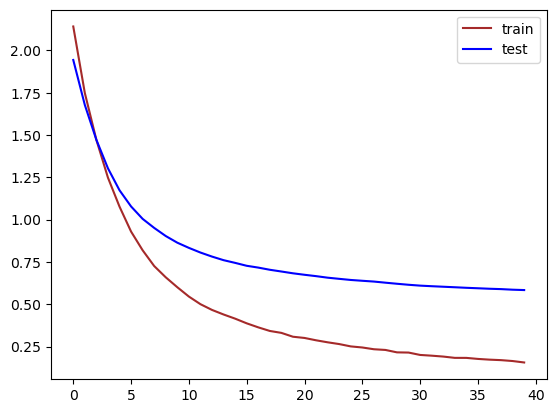

In [35]:
plt.plot(history.history['loss'], label='train', color='brown')
plt.plot(history.history['val_loss'], label='test', color='blue')

plt.legend()
plt.show()

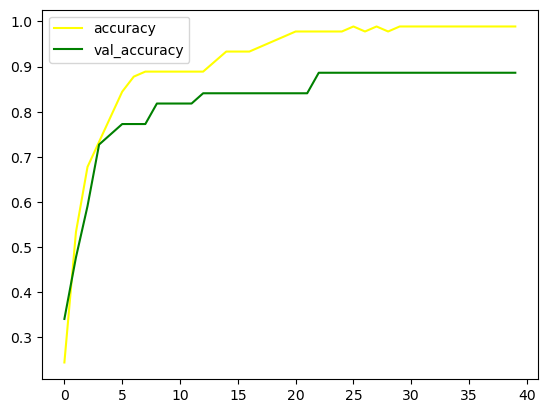

In [36]:
plt.plot(history.history['accuracy'], label='accuracy', color='yellow')
plt.plot(history.history['val_accuracy'], label='val_accuracy', color='green')
plt.legend()
plt.show()

In [37]:
tf.config.experimental.get_memory_info('GPU:0')

{'current': 18396672, 'peak': 8014269952}